<div><img src="https://www.ibm.com/blogs/bluemix/wp-content/uploads/2017/02/NLU.png", width=170, height=170, align = 'right'> 
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:0px 25px"></div>

# 航空公司客户价值分析（案例）
本文演示航空公司对不同价值的客户进行分类分析的方法。（文中所用为模拟数据）<br>
This notebook runs on Python 3.5 with Spark 2.1.

## 内容列表

1.  [实现目标](#lrfmc_1)<br>
2.  [数据探索](#lrfmc_2)<br>
3.  [数据处理](#lrfmc_3) <br>
 3.1.  [数据清洗，过滤掉不符合规则的数据](#lrfmc_3_1) <br>
 3.2.  [数据转换](#lrfmc_3_2) <br>
 3.3.  [标准差标准化](#lrfmc_3_3) <br>
4.  [模型构建](#lrfmc_4) <br>
 4.1.  [K-Means聚类算法,对数据进行分类](#lrfmc_4_1) <br>
 4.2.  [聚类结果分析](#lrfmc_4_2) <br>
 4.3.  [客户类型特征统计](#lrfmc_4_3) <br>
5.  [模型拟合原数据](#lrfmc_5) <br>
 5.1.  [将客户分类类型拟合到原数据](#lrfmc_5_1) <br>
 5.2.  [各客户类型数量统计](#lrfmc_5_2) <br>
 5.3. [针对(重要发展客户)做地址和年龄分布统计](#lrfmc_5_3) <br>

 <a id="lrfmc_1"></a>
# 1.根据客户数据,实现以下目标:
- 借助航空公司数据,对客户进行分类<br>
- 对不同的客户进行特征分析,比较不同的客户价值<br>
- 对不同客户价值的客户提供不同服务,指定相应的营销策略<br>

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from io import StringIO
import requests
import json
import numpy as np
import brunel
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns 

In [4]:
# The code was removed by DSX for sharing.

,会员卡号,入会时间,性别,工作地所在国家,工作地所在省份,年龄,观测窗口的结束时间,观测窗口内的飞行次数,观测窗口的总飞行公里数,平均折扣率,观测窗口的票价收入1,观测窗口的票价收入2
0,54993,2006/11/02,男,CN,北京,31.0,2014/03/31,210,580717,0.961639,239560.0,234188.0
1,28065,2007/02/19,男,CN,北京,42.0,2014/03/31,140,293678,1.252314,171483.0,167434.0
2,55106,2007/02/01,男,CN,北京,40.0,2014/03/31,135,283712,1.254676,163618.0,164982.0
3,21189,2008/08/22,男,US,CA,64.0,2014/03/31,23,281336,1.090870,116350.0,125500.0
4,39546,2009/04/10,男,CN,贵州,48.0,2014/03/31,152,309928,0.970658,124560.0,130702.0


<a id="lrfmc_2"></a>
# 2.对数据进行基本的探索
### 检查空值以及最小值

In [5]:
data_7_1 = df_data_1.describe(percentiles = [], include = 'all').T #包括对数据的基本描述，percentiles参数是指定计算多少的分位数表（如1/4分位数、中位数等）；T是转置，转置后更方便查阅
data_7_1['null'] = len(df_data_1)-data_7_1['count'] #describe()函数自动计算非空值数，需要手动计算空值数

data_7_1 = data_7_1[['null', 'max', 'min']]
data_7_1.columns = [u'空值数', u'最大值', u'最小值'] #表头重命名
'''这里只选取部分探索结果。
describe()函数自动计算的字段有count（非空值数）、unique（唯一值数）、top（频数最高者）、freq（最高频数）、mean（平均值）、std（方差）、min（最小值）、50%（中位数）、max（最大值）
'''
print(data_7_1.sort_index().tail(5))

             空值数     最大值  最小值
观测窗口的总飞行公里数    0  580717  368
观测窗口的票价收入1   551  239560    0
观测窗口的票价收入2   138  234188    0
观测窗口的结束时间      0     NaN  NaN
非乘机的积分变动次数     0     140    0


/usr/local/src/conda3_runtime.v22/4.1.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


<a id="lrfmc_3"></a>
# 3.数据处理
<a id="lrfmc_3_1"></a>
### 3.1 数据清洗，过滤掉不符合规则的数据<br>
丢弃票价为空的记录<br>
丢弃票价为0,平均折扣率为0,总飞行公里数大于0的记录

In [6]:
data_7_2 = df_data_1.copy()
data_7_2 = data_7_2[data_7_2['观测窗口的票价收入1'].notnull() & data_7_2['观测窗口的票价收入2'].notnull()] #票价非空值才保留

#只保留票价非零的，或者平均折扣率与总飞行公里数同时为0的记录。
index1 = data_7_2['观测窗口的票价收入1'] != 0
index2 = data_7_2['观测窗口的票价收入2'] != 0
index3 = (data_7_2['观测窗口的总飞行公里数'] == 0) & (data_7_2['平均折扣率'] == 0) #该规则是“与”
data_7_2 = data_7_2[index1 | index2 | index3] #该规则是“或”
#data_7_2_tmp = data_7_2.copy()
#data_7_2_tmp.columns = ['会员卡号','入会时间','第一次飞行日期','性别','会员卡级别','工作地城市','工作地所在省份','工作地所在国家','年龄','观测窗口的结束时间','观测窗口内的飞行次数','总基本积分','总基本积分年份1','总基本积分年份2','观测窗口的票价收入年份1','观测窗口的票价收入年份2','观测窗口的总飞行公里数','WEIGHTED_SEG_KM','末次飞行日期','平均飞行次数','平均基本积分','BEGIN_TO_FIRST','最后飞行时间距离观测窗口的时长','平均乘机时间间隔','最大乘机时间间隔','ADD_POINTS_SUM_YR_1','ADD_POINTS_SUM_YR_2','积分兑换次数','平均折扣率','P1Y_Flight_Count','L1Y_Flight_Count','P1Y_BP_SUM','L1Y_BP_SUM','总精英积分','ADD_Point_SUM','Eli_Add_Point_Sum','L1Y_ELi_Add_Points','Points_Sum','L1Y_Points_Sum','Ration_L1Y_Flight_Count','Ration_P1Y_Flight_Count','Ration_P1Y_BPS','Ration_L1Y_BPS','非乘机的积分变动次数']
data_7_2[['会员卡号','入会时间','性别','工作地所在国家','工作地所在省份','年龄','观测窗口的结束时间','观测窗口内的飞行次数','观测窗口的总飞行公里数','平均折扣率','观测窗口的票价收入1','观测窗口的票价收入2']].head(5)

,会员卡号,入会时间,性别,工作地所在国家,工作地所在省份,年龄,观测窗口的结束时间,观测窗口内的飞行次数,观测窗口的总飞行公里数,平均折扣率,观测窗口的票价收入1,观测窗口的票价收入2
0,54993,2006/11/02,男,CN,北京,31.0,2014/03/31,210,580717,0.961639,239560.0,234188.0
1,28065,2007/02/19,男,CN,北京,42.0,2014/03/31,140,293678,1.252314,171483.0,167434.0
2,55106,2007/02/01,男,CN,北京,40.0,2014/03/31,135,283712,1.254676,163618.0,164982.0
3,21189,2008/08/22,男,US,CA,64.0,2014/03/31,23,281336,1.090870,116350.0,125500.0
4,39546,2009/04/10,男,CN,贵州,48.0,2014/03/31,152,309928,0.970658,124560.0,130702.0


<a id="lrfmc_3_2"></a>
### 3.2 数据转换
#### LRFMC是验证客户是否是优质客户的指标
-  L = 观测窗口的结束时间 - 入会时间<br>
-  R = 最近一次乘坐时间至观察窗口末端时长<br>
-  F = 观测窗口的飞行次数<br>
-  M = 观测窗口的总飞行里数<br>
-  C = 平均折扣率<br>

In [7]:
data_7_2_rst = pd.DataFrame()
data_7_2_rst['L'] = pd.to_datetime(data_7_2['观测窗口的结束时间']) - pd.to_datetime(data_7_2['入会时间'])
data_7_2_rst['L'] = data_7_2_rst.L.map(lambda x: x/np.timedelta64(1*60*60*24*30, 's'))
data_7_2_rst['R'] = data_7_2['最后飞行时间距离观测窗口的时长'] / 30
data_7_2_rst['F'] = data_7_2['观测窗口内的飞行次数']
data_7_2_rst['M'] = data_7_2['观测窗口的总飞行公里数']
data_7_2_rst['C'] = data_7_2['平均折扣率']
data_7_2_rst = data_7_2_rst.round(2)
print (data_7_2_rst.head(5))

       L     R    F       M     C
0  90.20  0.03  210  580717  0.96
1  86.57  0.23  140  293678  1.25
2  87.17  0.37  135  283712  1.25
3  68.23  3.23   23  281336  1.09
4  60.53  0.17  152  309928  0.97


<a id="lrfmc_3_3"></a>
### 3.3 标准差标准化

In [8]:
data_7_3 = (data_7_2_rst - data_7_2_rst.mean(axis = 0))/(data_7_2_rst.std(axis = 0)) #简洁的语句实现了标准化变换，类似地可以实现任何想要的变换。
data_7_3.columns=['Z'+i for i in data_7_3.columns] #表头重命名。
print(data_7_3.head(5))

         ZL        ZR         ZF         ZM        ZC
0  1.435706 -0.945491  14.034016  26.761154  1.286487
1  1.307268 -0.912438   9.073213  13.126864  2.855183
2  1.328498 -0.889301   8.718869  12.653481  2.855183
3  0.658357 -0.416644   0.781585  12.540622  1.989695
4  0.385913 -0.922354   9.923636  13.898736  1.340580


<a id="lrfmc_4"></a>
# 4.模型构建
<a id="lrfmc_4_1"></a>
#### 4.1 K-Means聚类算法,对数据进行分类

In [9]:
k = 5        #需要进行的聚类类别数,这个demo即会生成 k 种类型的客户
#调用k-means算法，进行聚类分析
kmodel = KMeans(n_clusters = k, n_jobs = 1) #n_jobs是并行数，一般等于CPU数较好
kmodel.fit(data_7_3) #训练模型

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

<a id="lrfmc_4_2"></a>
#### 4.2 聚类结果分析:
- 重要保持客户:<br>
    这类客户平均折扣率(C)较高(乘坐的航班舱位等级高),最近乘坐本公司航班(R)低,次数(F)高或者里程(M)较高,这类客户贡献大,但是比例小,是理想客户类型<br>
- 重要发展客户:<br>
    这类客户平均折扣率(C)较高,最近乘坐本公司航班(R)低,次数(F)高或者里程(M)较低,入会时间(L)短,这类客户当前价值不高,但是有很大发展潜力<br>
- 重要挽留客户:<br>
    这类客户平均折扣率(C),次数(F)高或者里程(M)较高,但长时间没有坐过航班或者乘坐频率变小(R)高,这类客户价值变化不确定,客户衰退原因各不相同,公司应根据客户异常消费列出客户名单重点联系<br>
- 一般与低价值客户:<br>
    这类客户平均折扣率(C)很低,但长时间没有坐过航班(R)高,次数(F)高或者里程(M)较低,入会时间(L)短,这类客户是一般低价值客户,偶尔乘坐或者在打折促销时才会乘坐本公司航班<br>
    
##### 根据分析的客户类型可以看出模型导出的五种客户类型:
- 一般客户(General_Customer): 入会时间(L)短,折扣率(C)低,次数(F)里程(M)较高,属于一般客户
- 低价值客户(Low_Value_Customer): 入会时间(L)短,,(R)高,只是最近入会而且偶尔乘坐,属于低价值客户
- 重要发展客户(Important_Develop_Customer): 折扣率(C)高,入会时间(L)中规中矩,但是次数(F)里程(M)较低,说明刚开始乘坐本公司航班,但有价值,属于重要发展客户
- 重要保持客户(Important_Keep_Customer): 入会时间(L)次数(F)里程(M)平均折扣率(C)都高,(R)低,说明经常做而且舱位较高,属于重要保持客户
- 重要挽留客户(Important_Retention_Customer): 入会时间(L)较长,同时次数(F)里程(M)略高,属于重要挽留客户

In [10]:
kmodel_type = kmodel.cluster_centers_  #聚类产生的 k 种客户类型(每次返回的数据的顺序可能不同)
kmodel_value = kmodel.labels_           #每条数据对应聚类的结果

df_kmodel_type = pd.DataFrame(kmodel_type)
df_kmodel_type['TYPE'] = [x for x in range(5)] #客户类型标签
df_kmodel_type.columns = ['L','R','F','M','C','TYPE']
df_kmodel_type = df_kmodel_type.sort_values(by=['L'])\

print("客户类型种类:",df_kmodel_type)
print("每个客户所对应的客户类型:",kmodel_value)

客户类型种类:           L         R         F         M         C  TYPE
0 -0.700298 -0.415153 -0.160716 -0.160452 -0.256462     0
3 -0.313488  1.686675 -0.573887 -0.536642 -0.174768     3
1  0.049433 -0.002323 -0.231150 -0.235523  2.175753     1
2  0.483302 -0.799448  2.482617  2.423808  0.309897     2
4  1.160978 -0.377476 -0.086857 -0.094812 -0.157761     4
每个客户所对应的客户类型: [2 2 2 ..., 0 3 3]


<a id="lrfmc_4_3"></a>
#### 4.3 客户类型特征统计

[0.0, 1.2566370614359172, 2.5132741228718345, 3.7699111843077517, 5.026548245743669, 0.0]
[-0.7002976777909315, -0.4151527255375932, -0.1607156160145257, -0.1604520069260662, -0.2564617213784931]
[-0.3134876038964805, 1.6866746326897617, -0.5738874469272716, -0.5366423844837362, -0.1747683582181]
[0.04943290338703147, -0.0023233659021045304, -0.23115032348037323, -0.2355228626915738, 2.175752767569642]
[0.4833019133032434, -0.7994482875832671, 2.4826170916364467, 2.4238076786943674, 0.30989653846299975]
[1.1609784039631268, -0.3774762420405869, -0.08685700264141834, -0.09481230146905989, -0.15776069088006003]


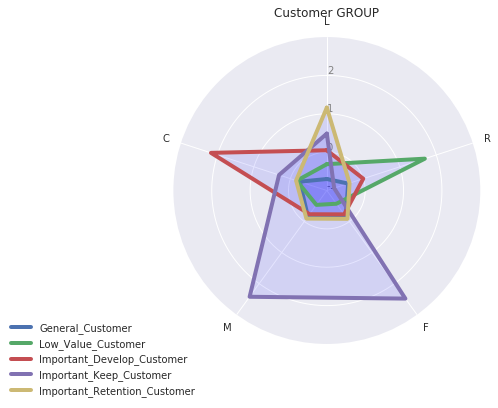

In [20]:
df = df_kmodel_type.iloc[:,0:5].copy()

# ------- PART 1: Create background
# number of variable
categories=list(df)
N = len(categories)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-1,0,1,2], ["-1","0","1","2"], color="grey", size=10)
plt.ylim(-1,3)
df['TYPE_NAME'] = ["General_Customer","Low_Value_Customer","Important_Develop_Customer","Important_Keep_Customer","Important_Retention_Customer"] 
# ------- PART 2: Add plots
# 添加客户类型对应的特征指标
for i in range(len(df)):
    # Ind1
    values=df.iloc[i:i+1,0:len(df)].values.flatten().tolist()
    print(values)
    values += values[:1]
    ax.plot(angles, values, linewidth=4, linestyle='solid', label=df.iloc[i:i+1,len(df):len(df)+1].values[0][0])
    ax.fill(angles, values, 'b', alpha=0.1)
    ax.set_title('Customer GROUP')
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

#### LRFMC是验证客户是否是优质客户的指标
-  L = 观测窗口的结束时间 - 入会时间<br>
-  R = 最近一次乘坐时间至观察窗口末端时长<br>
-  F = 观测窗口的飞行次数<br>
-  M = 观测窗口的总飞行里数<br>
-  C = 平均折扣率<br>

<a id="lrfmc_5"></a>
# 5.模型拟合原数据
<a id="lrfmc_5_1"></a>
### 5.1 将客户分类类型拟合到原数据

In [12]:
member_type = []
#客户分类后具体的客户类型
df_kmodel_type['TYPE_NAME'] = ["一般客户","低价值客户","重要发展客户","重要保持客户","重要挽留客户"]
for i in kmodel_value:
    member_type.append(df_kmodel_type.loc[i].TYPE_NAME)
data_7_2.insert(1,'TYPE',member_type)
index_val = data_7_2.index
member_type_data_1 = []
for index, val in df_data_1.iterrows():
    if index in (index_val.values):
        member_type_data_1.append(data_7_2.loc[index].TYPE)
    else:
        #数据无法统计的客户
        member_type_data_1.append("NA")
                                  
df_data_1.insert(1,'会员类型',member_type_data_1)
df_data_1[['会员卡号','会员类型','入会时间','性别','工作地所在国家','工作地所在省份','年龄','观测窗口的结束时间','观测窗口内的飞行次数','观测窗口的总飞行公里数','平均折扣率','观测窗口的票价收入1','观测窗口的票价收入2']].head(5)

,会员卡号,会员类型,入会时间,性别,工作地所在国家,工作地所在省份,年龄,观测窗口的结束时间,观测窗口内的飞行次数,观测窗口的总飞行公里数,平均折扣率,观测窗口的票价收入1,观测窗口的票价收入2
0,54993,重要保持客户,2006/11/02,男,CN,北京,31.0,2014/03/31,210,580717,0.961639,239560.0,234188.0
1,28065,重要保持客户,2007/02/19,男,CN,北京,42.0,2014/03/31,140,293678,1.252314,171483.0,167434.0
2,55106,重要保持客户,2007/02/01,男,CN,北京,40.0,2014/03/31,135,283712,1.254676,163618.0,164982.0
3,21189,重要保持客户,2008/08/22,男,US,CA,64.0,2014/03/31,23,281336,1.090870,116350.0,125500.0
4,39546,重要保持客户,2009/04/10,男,CN,贵州,48.0,2014/03/31,152,309928,0.970658,124560.0,130702.0


### 对数据进行统计

In [13]:
df_data_1_group = df_data_1.groupby('会员类型')
type_count = df_data_1_group.size().reset_index()
type_count.columns = ['TYPE','COUNT']
print(type_count)

     TYPE  COUNT
0      NA    944
1    一般客户  24636
2   低价值客户  12119
3  重要保持客户   5340
4  重要发展客户   4229
5  重要挽留客户  15720


<a id="lrfmc_5_2"></a>
### 5.2 各客户类型数量统计

In [14]:
%brunel data('type_count') bar x(TYPE) y(COUNT) color(COUNT) label(COUNT) style('.label{fill:white;text-shadow:none}') sort(TYPE) effect(enter:2000)  title("航空公司客户类型统计")  axes(y:2000:grid:"数量",x:6:"客户种类"):: width=800, height=300

<IPython.core.display.Javascript object>

<a id="lrfmc_5_3"></a>
### 5.3 针对[重要发展客户]做地址和年龄分布统计

In [15]:
#筛选出中国的数据
df_data_1_type_1 = df_data_1[(df_data_1.会员类型 == '重要发展客户') & (df_data_1.工作地所在国家 == 'CN')].copy()
df_data_1_type_1.工作地所在省份 = df_data_1_type_1.工作地所在省份.replace(r'\省','',regex=True)
df_data_1_type_1.工作地所在省份 = df_data_1_type_1.工作地所在省份.replace(r'\市|\.','',regex=True)
#df_data_1_type_1 = df_data_1_type_1.dropna()
#去除地址不正确的数据
#del_array = ['*', '-', '.','.北京','BEIJING','BEIJING','BRIARC','Beijing','Beijing','HONGKONG','HRB','HRB','IRVINE','LEEWOLDE','N','N','OSAKA','PARIS','STANLEY','TOKYO','leon','rotteadam','stratford','。','。','。','。']
#df_data_1_type_1_tmp = df_data_1_type_1[~ df_data_1_type_1.WORK_CITY.isin(del_array)]
#df_data_1_type_1_tmp['COUNT'] = 1
df_data_1_type_1_tmp_group = df_data_1_type_1.groupby('工作地所在省份').size().reset_index()
df_data_1_type_1_tmp_group.columns = ['LOCATION','COUNT']
print(df_data_1_type_1_tmp_group.tail(10))

   LOCATION  COUNT
66       贵州     25
67       贵阳      1
68       辽宁    297
69       重庆     19
70       长春      2
71       陕西     16
72       青海      6
73       香港      1
74      黑龙江     64
75        －      1


##### 重要发展客户地址分布

In [16]:
%brunel data('df_data_1_type_1_tmp_group') map('china')  x(LOCATION) color(COUNT:blues) label(LOCATION) tooltip(LOCATION,#all) legends(auto) interaction(select:mouseover) title("重要发展客户数量分布") :: width=800,height=500

<IPython.core.display.Javascript object>

##### 重要发展客户年龄统计

女 630     55.0
820     59.0
1048    40.0
1097    67.0
1256    55.0
Name: 年龄, dtype: float64
男 348    51.0
460    53.0
500    49.0
566    40.0
612    61.0
Name: 年龄, dtype: float64


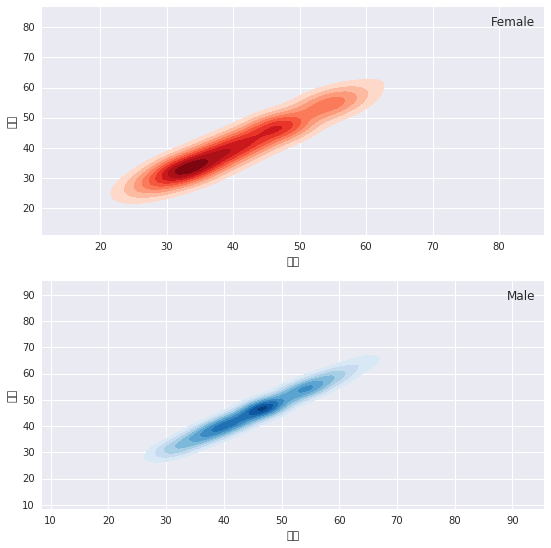

In [17]:
f,(axes1,axes2)=plt.subplots(2,1,figsize=(9,9),sharex=False,sharey=False)
data_age_f = df_data_1_type_1[df_data_1_type_1.性别=='女'].年龄.dropna() #女性年龄分布
data_age_m = df_data_1_type_1[df_data_1_type_1.性别=='男'].年龄.dropna() #男性年龄分布
print("女",data_age_f.head())
print("男",data_age_m.head())
sns.kdeplot(data_age_f,data_age_f,shade=True,cmap="Reds",shade_lowest=False,legend=True,ax=axes1)
axes1.legend('',title="Female")
sns.kdeplot(data_age_m,data_age_m,shade=True,cmap="Blues",shade_lowest=False,legend=True,ax=axes2)
axes2.legend('',title="Male")
'''
ax.get_legend().get_title().set_fontsize("14")
num = 0
colors = ['#FF0000','#0000CD']
for t in ax.get_legend().get_texts():
    t.set_fontsize('12')    # the legend text fontsize
    t.set_color(colors[num])    # the legend text color
    num = num + 1
'''
plt.show()

***
### 作者
**颜 晓超** 是在IBM从事数据分析的高级分析师，有丰富的针对企业客户开发和提供各类数据分析服务经验

<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>